# Why it’s time to stop processing satellite imagery on your laptop

## Haven’t moved to the cloud yet? Here's a good reason why you should!

### Use case: Detecting harvested fields with Sentinel-2 imagery

For this comparison exercise, we run a sample workflow that mimics a typical use case in remote sensing. Based on a pair of Sentinel-2 images, we will create a simple algorithm that detects crop-harvesting events. For this purpose, we will collect Sentinel-2 imagery for two cloud-free dates about 2 months apart in 2023. For each of these dates, we will extract [NDVI](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/) and identify large decreases in the index between the two dates. To reduce the likelihood of false positives due to crop senescence, we will calculate the [BSI](https://www.geo.university/pages/blog?p=spectral-indices-with-multispectral-satellite-data) and only consider harvested areas at locations where the BSI is above an empirical threshold on the second date.

_Note: The approach is for illustrative purposes only and is not a robust method for recognising harvests. The algorithm is used here to show typical band operations._

### Approaches

In a first method, we will look at a "traditional" approach, which consists of the following steps:

- download the Sentinel-2 scenes covering the area of interest (AOI)

- open the required bands (B04, B08, B11)

- cropping the bands to the AOI

- mosaic the bands

- calculation of the NDVI and BSI indices

- execution of band-wise operations

- filtering the data to reduce noise

- plotting the resulting map

In the second part of the notebook, we will obtain the same results by:

- running a Sentinel Hub request that directly returns the indices of interest

- filtering the data to reduce noise

- plotting the resulting map

### Summary statistics TO UPDATE!!!

The following table recapitulates the run times based on the two approaches.

|  | Traditional Workflow | Sentinel Hub Workflow |
|---|---|---|
| Lines of code (excluding imports) | ~450 | ~202 |
| Runtime | ~11 minutes | 5 seconds |
| Volume of data downloaded | 4.7 GB | 5.7MB |


This workflow was run on the Copernicus Data Space Ecosystem JupyterLab:

- CPU: 4 cores
- RAM: 16GB

At the time of the Sentinel-2 scenes download an internet speed test was performed, with the following results:

- Download: 96 Mbps
- Upload: 49 Mbps

## Library imports 

In [1]:
# General utilities
import getpass
import glob
import tarfile
import warnings
import zipfile
from pathlib import Path

# Plotting
import folium
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reading satellite imagery
import rasterio as rio
import requests
from matplotlib import colors
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject
from scipy.ndimage import morphology

# Sentinel Hub services
from sentinelhub import (
    CRS,
    DataCollection,
    Geometry,
    MimeType,
    SentinelHubRequest,
    SHConfig,
)
from shapely.geometry import shape

warnings.filterwarnings("ignore")

## Getting started: setup the Area of Interest 
For this comparison, we will extract satellite data over Volkmarsen and Bad Arolsen in the district of Waldeck-Frankenberg in the state of Hesse in north-west Germany.

In [3]:
area_of_interest = "data/EGU_aoi.geojson"

aoi = gpd.read_file(area_of_interest)
aoi_simplified = aoi.geometry.simplify(0.001)
aoi["geometry"] = aoi_simplified
aoi["area"] = aoi.area
aoi.explore("area", color="Green", legend=False)

# Part 1: Traditional workflow <a id='traditional_workflow'></a>

To begin with, we will show you how to run a traditional workflow. We will go through the data discovery, download, processing and visualisation of the imagery.

### 1. Discovering & Downloading the data via OData

A typical approach to retrieving Sentinel-2 imagery is to download the full tile. You can do this via the Copernicus Browser, where you can use this method to search for and download full tiles. The problem with this approach is that it takes time and cannot be automated. This can make the workflow cumbersome and not easily scalable. You can also download the data programmatically via the [OData API](https://documentation.dataspace.copernicus.eu/APIs/OData.html), which is what we will do in this example. OData (Open Data Protocol) is a standard that specifies a variety of best practices for creating and using REST APIs. OData makes it possible to build REST-based data services that let Web clients publish and edit resources that are recognized by Uniform Resource Locators (URLs) and described in a data model using straightforward HTTP messages.



In [4]:
# Set the directory where results will be stored
results_dir = "./data"

Let's define some of the inputs into the the request:

In [5]:
start_date = "2023-04-01"  # better to use start_date but I'd let you decide
end_date = "2023-05-01"
data_collection = "SENTINEL-2"
processing_level = "S2MSI2A"
aoi = aoi = aoi.dissolve()
request_aoi = aoi["geometry"][0]

Next, using the requests library we can build a our OData Request. In the request we have built below we have specified:
- *Product Type*: **S2MSI2A**
- Tiles intersecting the AOI
- *Time Range*: between **01/04/2023** & **01/05/2023**
- Cloud Cover percentage < **40%**


In [6]:
json = requests.get(
    "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Attributes/OData.CSC.StringAttribute/any(att:att/Name"
    " eq 'productType' and att/OData.CSC.StringAttribute/Value eq 'S2MSI2A') and"
    f" OData.CSC.Intersects(area=geography'SRID=4326;{request_aoi}') and ContentDate/Start gt {start_date}T00:00:00.000Z"
    f" and ContentDate/Start lt {end_date}T00:00:00.000Z and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq"
    " 'cloudCover' and att/OData.CSC.DoubleAttribute/Value le 40.00)&$top=10"
).json()
pd.DataFrame.from_dict(json["value"])

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,b32c0301-5734-4e7c-b930-9199d484b08c,S2A_MSIL2A_20230419T102601_N0509_R108_T32UMB_2...,application/octet-stream,1132744618,2023-04-19T20:09:10.751Z,2023-04-19T20:17:02.541Z,2023-05-16T00:28:38.574Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/04/19/S2A_MSIL...,[{}],"{'Start': '2023-04-19T10:26:01.024Z', 'End': '...",geography'SRID=4326;POLYGON ((7.56054785009126...,"{'type': 'Polygon', 'coordinates': [[[7.560547..."
1,application/octet-stream,e75ec9d3-40f9-4e01-85de-bd54bfeb334d,S2B_MSIL2A_20230404T102559_N0509_R108_T32UNC_2...,application/octet-stream,1172073222,2023-04-04T20:15:49.900Z,2023-04-04T20:22:39.716Z,2023-11-23T16:43:59.398Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/04/04/S2B_MSIL...,"[{'Value': 'aa6f7d8581b8c21a75c1bd47de25237b',...","{'Start': '2023-04-04T10:25:59.024Z', 'End': '...",geography'SRID=4326;POLYGON ((8.99970637088135...,"{'type': 'Polygon', 'coordinates': [[[8.999706..."
2,application/octet-stream,30ff05a3-4670-4bdc-bf55-3c26162c76c0,S2B_MSIL2A_20230404T102559_N0509_R108_T32UMB_2...,application/octet-stream,1199941384,2023-04-04T20:40:55.226Z,2023-04-04T20:52:05.716Z,2023-11-23T16:42:21.074Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/04/04/S2B_MSIL...,"[{'Value': '76bbe486c0431b10941be6e4a7d6634e',...","{'Start': '2023-04-04T10:25:59.024Z', 'End': '...",geography'SRID=4326;POLYGON ((7.56054785009126...,"{'type': 'Polygon', 'coordinates': [[[7.560547..."
3,application/octet-stream,ebfc333d-912a-4b04-8d06-3c5c976d13a8,S2B_MSIL2A_20230414T102559_N0509_R108_T32UMC_2...,application/octet-stream,1173233727,2023-04-14T16:04:31.635Z,2023-04-14T16:29:14.912Z,2023-11-22T19:48:17.595Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/04/14/S2B_MSIL...,"[{'Value': '93a191497ba9ae8d396738fb11a0b5f2',...","{'Start': '2023-04-14T10:25:59.024Z', 'End': '...",geography'SRID=4326;POLYGON ((7.5315289025883 ...,"{'type': 'Polygon', 'coordinates': [[[7.531528..."
4,application/octet-stream,7ff606eb-65a8-4fa1-9e98-1cbe9a24cf57,S2B_MSIL2A_20230404T102559_N0509_R108_T32UMC_2...,application/octet-stream,1189626377,2023-04-04T20:56:24.935Z,2023-04-04T21:04:35.262Z,2023-11-23T16:41:07.630Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/04/04/S2B_MSIL...,"[{'Value': 'd3669eaaa6dafc45b93c570c0f963a99',...","{'Start': '2023-04-04T10:25:59.024Z', 'End': '...",geography'SRID=4326;POLYGON ((7.5315289025883 ...,"{'type': 'Polygon', 'coordinates': [[[7.531528..."
5,application/octet-stream,ee036a9a-2622-4ba3-80b4-7ec13d7c2534,S2A_MSIL2A_20230419T102601_N0509_R108_T32UMC_2...,application/octet-stream,1195975631,2023-04-19T20:16:12.269Z,2023-04-19T20:34:03.661Z,2023-05-16T00:29:00.402Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/04/19/S2A_MSIL...,[{}],"{'Start': '2023-04-19T10:26:01.024Z', 'End': '...",geography'SRID=4326;POLYGON ((7.5315289025883 ...,"{'type': 'Polygon', 'coordinates': [[[7.531528..."
6,application/octet-stream,00d1e5b6-177d-4fce-a439-78e2b37689a4,S2A_MSIL2A_20230419T102601_N0509_R108_T32UNC_2...,application/octet-stream,1181366678,2023-04-19T19:53:00.636Z,2023-04-19T20:19:40.941Z,2023-05-16T00:28:01.213Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/04/19/S2A_MSIL...,[{}],"{'Start': '2023-04-19T10:26:01.024Z', 'End': '...",geography'SRID=4326;POLYGON ((8.99970637088135...,"{'type': 'Polygon', 'coordinates': [[[8.999706..."
7,application/octet-stream,ecee5698-f4b2-4336-860a-8d6fb867cae2,S2A_MSIL2A_20230419T102601_N0509_R108_T32UNB_2...,application/octet-stream,1183144695,2023-04-19T20:05:10.241Z,2023-04-19T20:13:31.711Z,2023-05-16T00:28:27.058Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/04/19/S2A_MSIL...,[{}],"{'Start': '2023-04-19T10:26:01.024Z', 'End': '...",geography'SRID=4326;POLYGON ((8.9997121758513 ...,"{'type': 'Polygon', 'coordinates': [[[8.999712..."


Now, we have the results from the request, we can examine them further extracting out the tile *Name*, *GeoFootprint* and *Id*. We can then convert this into a GeoPandas dataframe and visualise the tiles and AOI together:

In [7]:
tiles = pd.DataFrame.from_dict(json["value"])

In [8]:
tile_footprints = tiles[["Name", "GeoFootprint", "Id"]]
tile_footprints

,Name,GeoFootprint,Id
0,S2A_MSIL2A_20230419T102601_N0509_R108_T32UMB_2...,"{'type': 'Polygon', 'coordinates': [[[7.560547...",b32c0301-5734-4e7c-b930-9199d484b08c
1,S2B_MSIL2A_20230404T102559_N0509_R108_T32UNC_2...,"{'type': 'Polygon', 'coordinates': [[[8.999706...",e75ec9d3-40f9-4e01-85de-bd54bfeb334d
2,S2B_MSIL2A_20230404T102559_N0509_R108_T32UMB_2...,"{'type': 'Polygon', 'coordinates': [[[7.560547...",30ff05a3-4670-4bdc-bf55-3c26162c76c0
3,S2B_MSIL2A_20230414T102559_N0509_R108_T32UMC_2...,"{'type': 'Polygon', 'coordinates': [[[7.531528...",ebfc333d-912a-4b04-8d06-3c5c976d13a8
4,S2B_MSIL2A_20230404T102559_N0509_R108_T32UMC_2...,"{'type': 'Polygon', 'coordinates': [[[7.531528...",7ff606eb-65a8-4fa1-9e98-1cbe9a24cf57
5,S2A_MSIL2A_20230419T102601_N0509_R108_T32UMC_2...,"{'type': 'Polygon', 'coordinates': [[[7.531528...",ee036a9a-2622-4ba3-80b4-7ec13d7c2534
6,S2A_MSIL2A_20230419T102601_N0509_R108_T32UNC_2...,"{'type': 'Polygon', 'coordinates': [[[8.999706...",00d1e5b6-177d-4fce-a439-78e2b37689a4
7,S2A_MSIL2A_20230419T102601_N0509_R108_T32UNB_2...,"{'type': 'Polygon', 'coordinates': [[[8.999712...",ecee5698-f4b2-4336-860a-8d6fb867cae2


In [9]:
geom = [shape(i) for i in tile_footprints.GeoFootprint]
geom  # can be removed
tile_footprints2 = tile_footprints.assign(geometry=geom)
tile_footprints3 = tile_footprints2.drop(["GeoFootprint"], axis=1, inplace=False)
sen2_tiles_before = gpd.GeoDataFrame(tile_footprints3)
sen2_tiles_before = sen2_tiles_before.set_crs("EPSG:4326")
sen2_tiles_before

,Name,Id,geometry
0,S2A_MSIL2A_20230419T102601_N0509_R108_T32UMB_2...,b32c0301-5734-4e7c-b930-9199d484b08c,"POLYGON ((7.56055 51.44235, 7.59072 50.45527, ..."
1,S2B_MSIL2A_20230404T102559_N0509_R108_T32UNC_2...,e75ec9d3-40f9-4e01-85de-bd54bfeb334d,"POLYGON ((8.99971 52.35047, 8.99971 51.36324, ..."
2,S2B_MSIL2A_20230404T102559_N0509_R108_T32UMB_2...,30ff05a3-4670-4bdc-bf55-3c26162c76c0,"POLYGON ((7.56055 51.44235, 7.59072 50.45527, ..."
3,S2B_MSIL2A_20230414T102559_N0509_R108_T32UMC_2...,ebfc333d-912a-4b04-8d06-3c5c976d13a8,"POLYGON ((7.53153 52.34135, 7.56331 51.35443, ..."
4,S2B_MSIL2A_20230404T102559_N0509_R108_T32UMC_2...,7ff606eb-65a8-4fa1-9e98-1cbe9a24cf57,"POLYGON ((7.53153 52.34135, 7.56331 51.35443, ..."
5,S2A_MSIL2A_20230419T102601_N0509_R108_T32UMC_2...,ee036a9a-2622-4ba3-80b4-7ec13d7c2534,"POLYGON ((7.53153 52.34135, 7.56331 51.35443, ..."
6,S2A_MSIL2A_20230419T102601_N0509_R108_T32UNC_2...,00d1e5b6-177d-4fce-a439-78e2b37689a4,"POLYGON ((8.99971 52.35047, 8.99971 51.36324, ..."
7,S2A_MSIL2A_20230419T102601_N0509_R108_T32UNB_2...,ecee5698-f4b2-4336-860a-8d6fb867cae2,"POLYGON ((8.99971 51.45118, 8.99972 50.46380, ..."


In [10]:
m = sen2_tiles_before.explore(
    style_kwds=dict(color="blue", weight=1, opacity=0.1, fillOpacity=0.2), legend=False
)

aoi.explore(m=m, color="Red", legend=False)

folium.TileLayer("CartoDB positron", show=False).add_to(
    m
)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m  # show map

We can see that our AOI is intersected by four Sentinel-2 tiles. We can only achieve full coverage if we select all four of these tiles. Using this extreme example, you can see that in some situations you may be forced to download multiple tiles, as an AOI can easily cover an area that is not completely intersected fully by a single Sentinel-2 tile.

### Retrieving your Access Token

Whilst no credentials are needed to search the catalogue; in order to download products from Copernicus Data Space Ecosystem catalogue using OData and OpenSearch API users are required to have an Access token. This token can be generated in both Linux and Window OS using either `cURL` or `python` script. You can generate this token using the following code block (more information can be found in our [documentation](https://documentation.dataspace.copernicus.eu/APIs/Token.html)).

To obtain your token, you are required to provide your Copernicus Data Space Ecosystem `username` and `password`. In this example, we import them from a Python file called `creds.py` and import the credentials as variables into the `get_access_token()` function (To run the following cell yourself, you will need to create this file yourself). 

In [12]:
def get_access_token(username: str, password: str) -> str:
    data = {
        "client_id": "cdse-public",
        "username": username,
        "password": password,
        "grant_type": "password",
    }
    try:
        r = requests.post(
            "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
            data=data,
        )
        r.raise_for_status()
    except Exception as e:
        raise Exception(
            f"Access token creation failed. Reponse from the server was: {r.json()}"
        )
    return r.json()["access_token"]


access_token = get_access_token(
    getpass.getpass("Enter your username"),
    getpass.getpass("Enter your password"),
)

Enter your username ········
Enter your password ········


In [13]:
sen2_tile_id_before = sen2_tiles_before["Id"]

tile_list_before = [
    sen2_tile_id_before[1],
    sen2_tile_id_before[2],
    sen2_tile_id_before[5],
    sen2_tile_id_before[6],
]
tile_list_before

['e75ec9d3-40f9-4e01-85de-bd54bfeb334d',
 '30ff05a3-4670-4bdc-bf55-3c26162c76c0',
 'ee036a9a-2622-4ba3-80b4-7ec13d7c2534',
 '00d1e5b6-177d-4fce-a439-78e2b37689a4']

In [14]:
for tile in tile_list_before:
    url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({tile})/$value"

    headers = {"Authorization": f"Bearer {access_token}"}

    session = requests.Session()
    session.headers.update(headers)
    response = session.get(url, headers=headers, stream=True)

    with open(f"{tile}.zip", "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                file.write(chunk)

Now we repeat the process again to search and discover the after image for our application and then download it:

In [15]:
start_date = "2023-07-01"  # nicer to use start_date
end_date = "2023-08-01"
data_collection = "SENTINEL-2"
processing_level = "S2MSI2A"
request_aoi = aoi["geometry"][0]

In [16]:
json = requests.get(
    "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Attributes/OData.CSC.StringAttribute/any(att:att/Name"
    " eq 'productType' and att/OData.CSC.StringAttribute/Value eq 'S2MSI2A') and"
    f" OData.CSC.Intersects(area=geography'SRID=4326;{request_aoi}') and ContentDate/Start gt {start_date}T00:00:00.000Z"
    f" and ContentDate/Start lt {end_date}T00:00:00.000Z and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq"
    " 'cloudCover' and att/OData.CSC.DoubleAttribute/Value le 30.00)&$top=10"
).json()
pd.DataFrame.from_dict(json["value"])

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,408da605-0740-49cf-b4fd-e55386833a9c,S2A_MSIL2A_20230708T102601_N0509_R108_T32UMC_2...,application/octet-stream,1222379890,2023-07-08T19:58:50.468Z,2023-07-08T20:07:04.014Z,2023-07-08T20:08:21.867Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/07/08/S2A_MSIL...,"[{'Value': '256134d5c4f44ce37beb9dac028edc00',...","{'Start': '2023-07-08T10:26:01.024Z', 'End': '...",geography'SRID=4326;POLYGON ((7.5315289025883 ...,"{'type': 'Polygon', 'coordinates': [[[7.531528..."
1,application/octet-stream,22ae4fae-25e9-44ba-b57b-106c3ae5e54d,S2A_MSIL2A_20230708T102601_N0509_R108_T32UNC_2...,application/octet-stream,1192429311,2023-07-08T20:23:11.564Z,2023-07-08T20:31:37.790Z,2023-07-08T20:33:55.197Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/07/08/S2A_MSIL...,"[{'Value': '9100e8fddfb73fe5f2108b422cee8569',...","{'Start': '2023-07-08T10:26:01.024Z', 'End': '...",geography'SRID=4326;POLYGON ((8.99970637088135...,"{'type': 'Polygon', 'coordinates': [[[8.999706..."
2,application/octet-stream,babe51f9-5be2-4403-99b4-d273ded1fa19,S2A_MSIL2A_20230708T102601_N0509_R108_T32UMB_2...,application/octet-stream,1210401547,2023-07-08T20:09:10.415Z,2023-07-08T20:16:50.362Z,2023-07-08T20:17:07.730Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/07/08/S2A_MSIL...,"[{'Value': '9b17587c06f5313fce9f0a389152d0d2',...","{'Start': '2023-07-08T10:26:01.024Z', 'End': '...",geography'SRID=4326;POLYGON ((7.56054785009126...,"{'type': 'Polygon', 'coordinates': [[[7.560547..."
3,application/octet-stream,93d216ee-84a3-4480-a28b-666ed5cb77ee,S2A_MSIL2A_20230708T102601_N0509_R108_T32UNB_2...,application/octet-stream,1183436241,2023-07-08T20:17:11.381Z,2023-07-08T20:24:26.718Z,2023-07-08T20:24:39.283Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/07/08/S2A_MSIL...,"[{'Value': 'a723fedecf8bf1fdd57cd6e4dfdd1119',...","{'Start': '2023-07-08T10:26:01.024Z', 'End': '...",geography'SRID=4326;POLYGON ((8.9997121758513 ...,"{'type': 'Polygon', 'coordinates': [[[8.999712..."


In [17]:
tiles = pd.DataFrame.from_dict(json["value"])

In [18]:
tile_footprints = tiles[["Name", "GeoFootprint", "Id"]]
tile_footprints

,Name,GeoFootprint,Id
0,S2A_MSIL2A_20230708T102601_N0509_R108_T32UMC_2...,"{'type': 'Polygon', 'coordinates': [[[7.531528...",408da605-0740-49cf-b4fd-e55386833a9c
1,S2A_MSIL2A_20230708T102601_N0509_R108_T32UNC_2...,"{'type': 'Polygon', 'coordinates': [[[8.999706...",22ae4fae-25e9-44ba-b57b-106c3ae5e54d
2,S2A_MSIL2A_20230708T102601_N0509_R108_T32UMB_2...,"{'type': 'Polygon', 'coordinates': [[[7.560547...",babe51f9-5be2-4403-99b4-d273ded1fa19
3,S2A_MSIL2A_20230708T102601_N0509_R108_T32UNB_2...,"{'type': 'Polygon', 'coordinates': [[[8.999712...",93d216ee-84a3-4480-a28b-666ed5cb77ee


In [19]:
geom = [shape(i) for i in tile_footprints.GeoFootprint]
geom
tile_footprints2 = tile_footprints.assign(geometry=geom)
tile_footprints3 = tile_footprints2.drop(["GeoFootprint"], axis=1, inplace=False)
sen2_tiles_after = gpd.GeoDataFrame(tile_footprints3)
sen2_tiles_after = sen2_tiles_after.set_crs("EPSG:4326")
sen2_tiles_after

,Name,Id,geometry
0,S2A_MSIL2A_20230708T102601_N0509_R108_T32UMC_2...,408da605-0740-49cf-b4fd-e55386833a9c,"POLYGON ((7.53153 52.34135, 7.56331 51.35443, ..."
1,S2A_MSIL2A_20230708T102601_N0509_R108_T32UNC_2...,22ae4fae-25e9-44ba-b57b-106c3ae5e54d,"POLYGON ((8.99971 52.35047, 8.99971 51.36324, ..."
2,S2A_MSIL2A_20230708T102601_N0509_R108_T32UMB_2...,babe51f9-5be2-4403-99b4-d273ded1fa19,"POLYGON ((7.56055 51.44235, 7.59072 50.45527, ..."
3,S2A_MSIL2A_20230708T102601_N0509_R108_T32UNB_2...,93d216ee-84a3-4480-a28b-666ed5cb77ee,"POLYGON ((8.99971 51.45118, 8.99972 50.46380, ..."


In [20]:
sen2_tile_id_after = sen2_tiles_after["Id"]

tile_list_after = [
    sen2_tile_id_after[0],
    sen2_tile_id_after[1],
    sen2_tile_id_after[2],
    sen2_tile_id_after[3],
]
tile_list_after

['408da605-0740-49cf-b4fd-e55386833a9c',
 '22ae4fae-25e9-44ba-b57b-106c3ae5e54d',
 'babe51f9-5be2-4403-99b4-d273ded1fa19',
 '93d216ee-84a3-4480-a28b-666ed5cb77ee']

In [21]:
access_token = get_access_token(
    getpass.getpass("Enter your username"),
    getpass.getpass("Enter your password"),
)

Enter your username ········
Enter your password ········


In [22]:
for tile in tile_list_after:
    url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({tile})/$value"

    headers = {"Authorization": f"Bearer {access_token}"}

    session = requests.Session()
    session.headers.update(headers)
    response = session.get(url, headers=headers, stream=True)

    with open(f"{tile}.zip", "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                file.write(chunk)

Finally, now that both the before and after images have been downloaded, we can unzip the zip files and begin to process the data using the below cell:

In [23]:
for unziptile in tile_list_before:
    with zipfile.ZipFile(f"{unziptile}.zip", "r") as zip_ref:
        zip_ref.extractall("./data/before/")

for unziptile in tile_list_after:
    with zipfile.ZipFile(f"{unziptile}.zip", "r") as zip_ref:
        zip_ref.extractall("./data/after/")

### 2. Process data

In the step below; some helper functions to process the raster files with Rasterio are defined.

In [24]:
def crop_rasters(filenames, aoi, nodata, output_path, nd=65535):
    """Crop a list of rasters based on a AOI and save the outputs."""
    output_files = []

    for f in filenames:
        with rio.open(f) as raster:
            # Get crs from profile and convert input aoi
            profile = raster.profile
            crop_bound = aoi.to_crs(profile["crs"])

            # Mask raster
            out_img, out_transform = mask(
                raster, shapes=crop_bound, crop=True, nodata=nd
            )

            # Save raster
            output_files.append(f"{output_path}/{Path(f).stem}_crop.tiff")
            write_raster(
                f"{output_path}/{Path(f).stem}_crop.tiff",
                out_img[0, :, :],
                profile["crs"],
                out_transform,
                nd,
                driver="GTiff",
            )

    return output_files


def mosaic_rasters(filenames):
    """Mosaic several rasters."""
    to_mosaic = []
    crs = []
    nodata = []

    for file in filenames:
        src = rio.open(file, masked=True)
        nodata.append(src.nodata)
        to_mosaic.append(src)
        crs.append(src.profile["crs"])

    mosaic, transform = merge(to_mosaic)

    if not all(x == crs[0] for x in crs):
        raise ValueError("Not all files in the same projection!")

    if not all(x == nodata[0] for x in nodata):
        raise ValueError("Not all file have the same nodata mask!")

    return np.where(mosaic == nodata[0], np.nan, mosaic), transform, crs[0]


def rio_resample(method):
    """Return a rasterio resampling method based on a string."""

    resampling_methods = {
        "nearest": rio.enums.Resampling.nearest,
        "bilinear": rio.enums.Resampling.bilinear,
        "cubic": rio.enums.Resampling.cubic,
        "cubic_spline": rio.enums.Resampling.cubic_spline,
        "lanczos": rio.enums.Resampling.lanczos,
        "average": rio.enums.Resampling.average,
        "mode": rio.enums.Resampling.mode,
        "gauss": rio.enums.Resampling.gauss,
        "max": rio.enums.Resampling.max,
        "min": rio.enums.Resampling.min,
        "med": rio.enums.Resampling.med,
        "q1": rio.enums.Resampling.q1,
        "q3": rio.enums.Resampling.q3,
        "sum": rio.enums.Resampling.sum,
        "rms": rio.enums.Resampling.rms,
    }

    if method not in resampling_methods:
        raise ValueError(
            "Wrong resampling method selected."
            " See: https://rasterio.readthedocs.io/en/latest/api/rasterio.enums."
            "html#rasterio.enums.Resampling"
        )

    return resampling_methods[method]


def resample_rasters(filenames, upscale_factor, output_path, method="nearest"):
    """Resample list of rasters."""
    output_files = []

    for file in filenames:
        src = rio.open(file)

        # resample data to target shape
        data = src.read(
            out_shape=(
                src.count,
                int(src.height * upscale_factor),
                int(src.width * upscale_factor),
            ),
            resampling=rio_resample(method),
        )

        # scale image transform
        transform = src.transform * src.transform.scale(
            (src.width / data.shape[-1]), (src.height / data.shape[-2])
        )

        # Save rasters
        output_files.append(f"{output_path}/{Path(file).stem}_resampled.tiff")
        write_raster(
            f"{output_path}/{Path(file).stem}_resampled.tiff",
            data[0, :, :],
            src.profile["crs"],
            transform,
            65535,
        )

    return output_files


def reproject_raster(inpath, outpath, crs, method="nearest"):
    "Reproject a raster to a new coordinate system."

    dst_crs = f"EPSG:{crs}"

    with rio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update(
            {"crs": dst_crs, "transform": transform, "width": width, "height": height}
        )

        with rio.open(outpath, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=rio_resample(method),
                )


def write_raster(path, raster, crs, transform, nodata, driver="GTiff"):
    """Write a raster to a file."""

    with rio.open(
        path,
        "w",
        driver=driver,
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs=crs,
        transform=transform,
        nodata=nodata,
    ) as dst:
        dst.write(raster, 1)

#### Date 1

In a first step we will search for all the Band 4 and Band 8 files in the selected products covering our area of interest.

In [25]:
bands = glob.glob("data/before/**/*B0[4-8]_10m.jp2", recursive=True)

# Extract bands 4 and 8 paths and group them
bands_B04 = [
    x for x in bands if "B04" in x
]  # nicer to use bands_b04 and same for others
bands_B08 = [x for x in bands if "B08" in x]

In [26]:
cropped_B04 = crop_rasters(bands_B04, aoi.geometry, 65535, results_dir)
cropped_B08 = crop_rasters(bands_B08, aoi.geometry, 65535, results_dir)

In [27]:
mosaic_B04, trans_B04, crs_B04 = mosaic_rasters(cropped_B04)
mosaic_B08, trans_B08, crs_B08 = mosaic_rasters(cropped_B08)

To avoid opening and processing the entires scenes, we will crop the bands to our area of interest (AOI).

Now we calculate the NDVI for the first date.

In [28]:
ndvi_t1 = (mosaic_B08 - mosaic_B04) / (mosaic_B08 + mosaic_B04)

We can save this intermediate result to a file.

In [29]:
write_raster(
    f"{results_dir}/NDVI_date1.tif", ndvi_t1[0, :, :], crs_B04, trans_B04, -9999
)

#### Date 2

For the second date, we need more bands because we want to compute NDVI and BSI. We start by filtering the bands of interest.

In [30]:
bands_t2 = glob.glob("data/after/**/*B[0-8][0-8]*.jp2", recursive=True)

# Extract bands 4 and 8 paths and group them
bands_B02 = [x for x in bands_t2 if ("B02" in x) and ("10m" in x)]
bands_B04 = [x for x in bands_t2 if ("B04" in x) and ("10m" in x)]
bands_B08 = [x for x in bands_t2 if ("B08" in x) and ("10m" in x)]
bands_B11 = [
    x for x in bands_t2 if ("B11" in x) and ("20m" in x)
]  # B11 at 20m resolution

Band 11 comes with a spatial resolution of 20m (see [documentation](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial)). In order to perform band-wise operations with the other bands at a 10-meter resolution, we need to resample the band (by a factor of 2).

In [31]:
resampled_B11 = resample_rasters(bands_B11, 2, results_dir, method="nearest")

To avoid opening and processing the entires scenes, we will crop the bands to our area of interest (AOI).

In [32]:
cropped_B02 = crop_rasters(bands_B02, aoi.geometry, 65535, results_dir)
cropped_B04 = crop_rasters(bands_B04, aoi.geometry, 65535, results_dir)
cropped_B08 = crop_rasters(bands_B08, aoi.geometry, 65535, results_dir)
cropped_B11 = crop_rasters(resampled_B11, aoi.geometry, 65535, results_dir)

In [33]:
mosaic_B02, trans_B02, crs_B02 = mosaic_rasters(cropped_B02)
mosaic_B04, trans_B04, crs_B04 = mosaic_rasters(cropped_B04)
mosaic_B08, trans_B08, crs_B08 = mosaic_rasters(cropped_B08)
mosaic_B11, trans_B11, crs_B11 = mosaic_rasters(cropped_B11)

Now we calculate NDVI and BSI for the second date.

In [34]:
ndvi_t2 = (mosaic_B08 - mosaic_B04) / (mosaic_B08 + mosaic_B04)
bsi_t2 = ((mosaic_B11 + mosaic_B04) - (mosaic_B08 + mosaic_B02)) / (
    (mosaic_B11 + mosaic_B04) + (mosaic_B08 + mosaic_B02)
)

We can save this intermediate result to a file.

In [35]:
write_raster(
    f"{results_dir}/NDVI_date2.tif", ndvi_t2[0, :, :], crs_B04, trans_B04, -9999
)
write_raster(f"{results_dir}/BSI_date2.tif", bsi_t2[0, :, :], crs_B04, trans_B04, -9999)

In the last step of the calculations, we compute the harvested product based on empirical products. We consider a field to be harvested if the decrese in NDVI between the two dates is larger than 0.25, and to remove false positives due to plant senescence, we only consider an area to be harvested if the BSI is larger than 0.15.

In [36]:
harvested = np.where((ndvi_t1 - ndvi_t2 > 0.1) & (bsi_t2 > 0.1), 1, 0)

### 3. Plot data

In the next cells, we will plot the different products obtained from our processing chain.

We will start with the NDVI product for the first date.

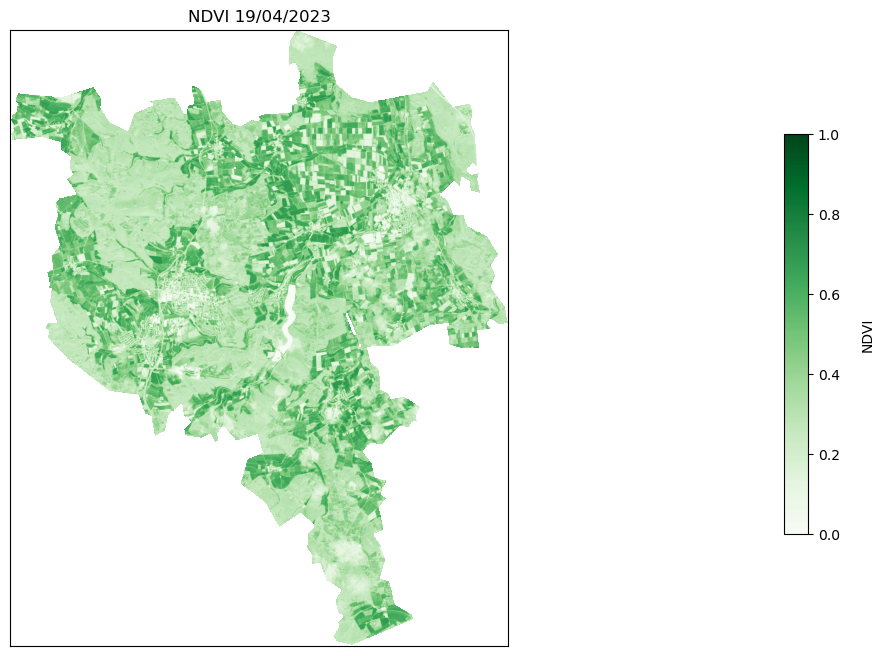

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(ndvi_t1[0, :, :], cmap="Greens", vmin=0, vmax=1)
cax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cax, orientation="vertical")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("NDVI", rotation=90)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("NDVI 19/04/2023")
plt.show()

Next, we will plot the NDVI product for the second date.

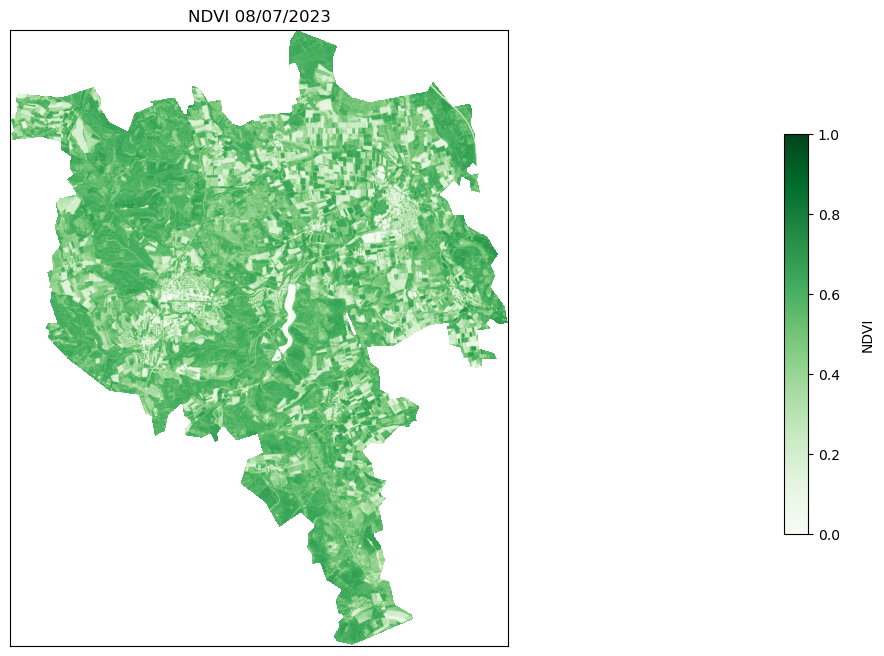

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(ndvi_t2[0, :, :], cmap="Greens", vmin=0, vmax=1)
cax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cax, orientation="vertical")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("NDVI", rotation=90)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("NDVI 08/07/2023")
plt.show()

In the following cell we will plot the BSI for the second date.

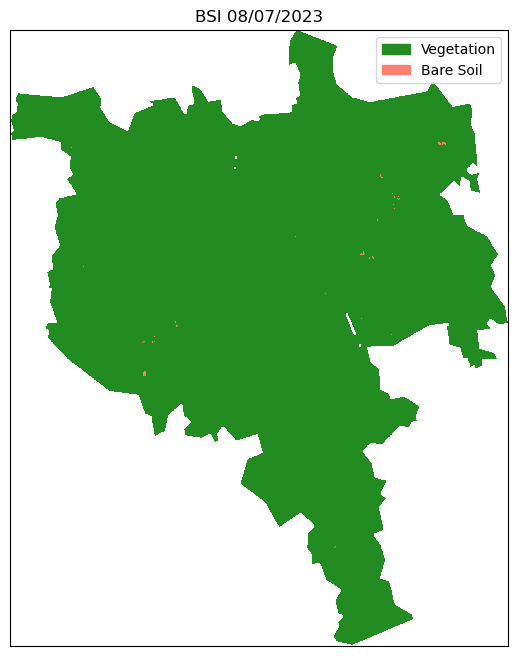

In [39]:
cmap_bsi = colors.ListedColormap(["forestgreen", "salmon"])
bounds_bsi = [-10, 0.15, 10]
norm_bsi = colors.BoundaryNorm(bounds_bsi, cmap_bsi.N)

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(bsi_t2[0, :, :], cmap=cmap_bsi, norm=norm_bsi)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(
    handles=[
        mpatches.Patch(color="forestgreen", label="Vegetation"),
        mpatches.Patch(color="salmon", label="Bare Soil"),
    ]
)
ax.set_title("BSI 08/07/2023")


plt.show()

Next, we plot the "harvested" product.

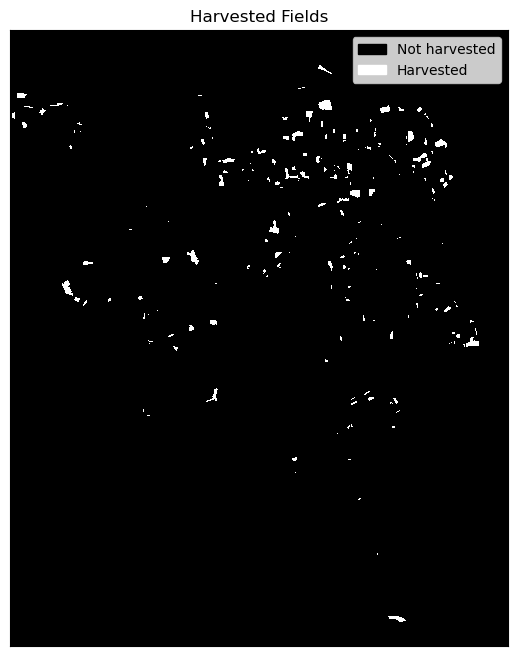

In [40]:
cmap_harvested = colors.ListedColormap(["black", "white"])
bounds_harvested = [0, 0.5, 1]
norm_harvested = colors.BoundaryNorm(bounds_harvested, cmap_harvested.N)

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(harvested[0, :, :], cmap=cmap_harvested, norm=norm_harvested)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(
    handles=[
        mpatches.Patch(color="black", label="Not harvested"),
        mpatches.Patch(color="white", label="Harvested"),
    ]
)
ax.set_title("Harvested Fields")


plt.show()

As we can see in the figure above, the resulting layer is quite noisy, with many very small patches (a few pixels) identified as harvested areas. Since we are only interested in identifying the harvested patches, we can clean up the dataset by applying a binary opening function. A binary opening is the dilation of the erosion of the image, which removes the smaller clumps of pixels.

In [41]:
harvested_cleaned = morphology.binary_opening(
    harvested[0, :, :], structure=np.ones((5, 5))
).astype(np.int8)

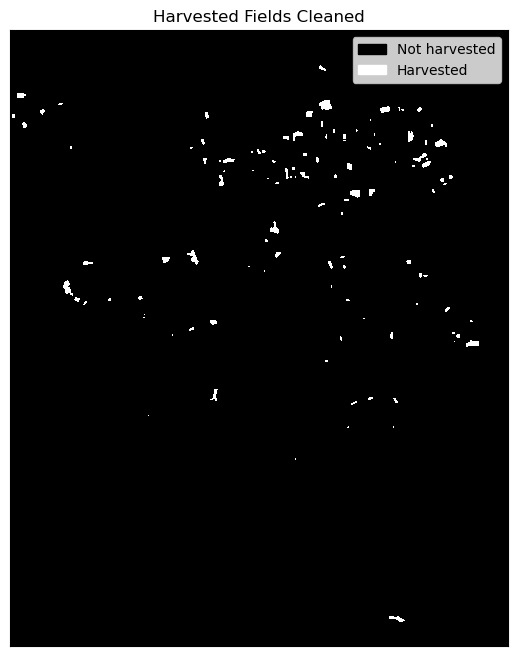

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(harvested_cleaned, cmap=cmap_harvested, norm=norm_harvested)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(
    handles=[
        mpatches.Patch(color="black", label="Not harvested"),
        mpatches.Patch(color="white", label="Harvested"),
    ]
)
ax.set_title("Harvested Fields Cleaned")

plt.show()

You can try different methods to clean the dataset. Once we are satisfied with the results, we can write them to a file.

In [43]:
write_raster(
    f"{results_dir}/harvested_fields.tif",
    harvested_cleaned.astype("uint8"),
    crs_B04,
    trans_B04,
    0,
)

To be able to plot the data on an interactive map, we will reproject the resulting geotiff to `EPSG:4326`.


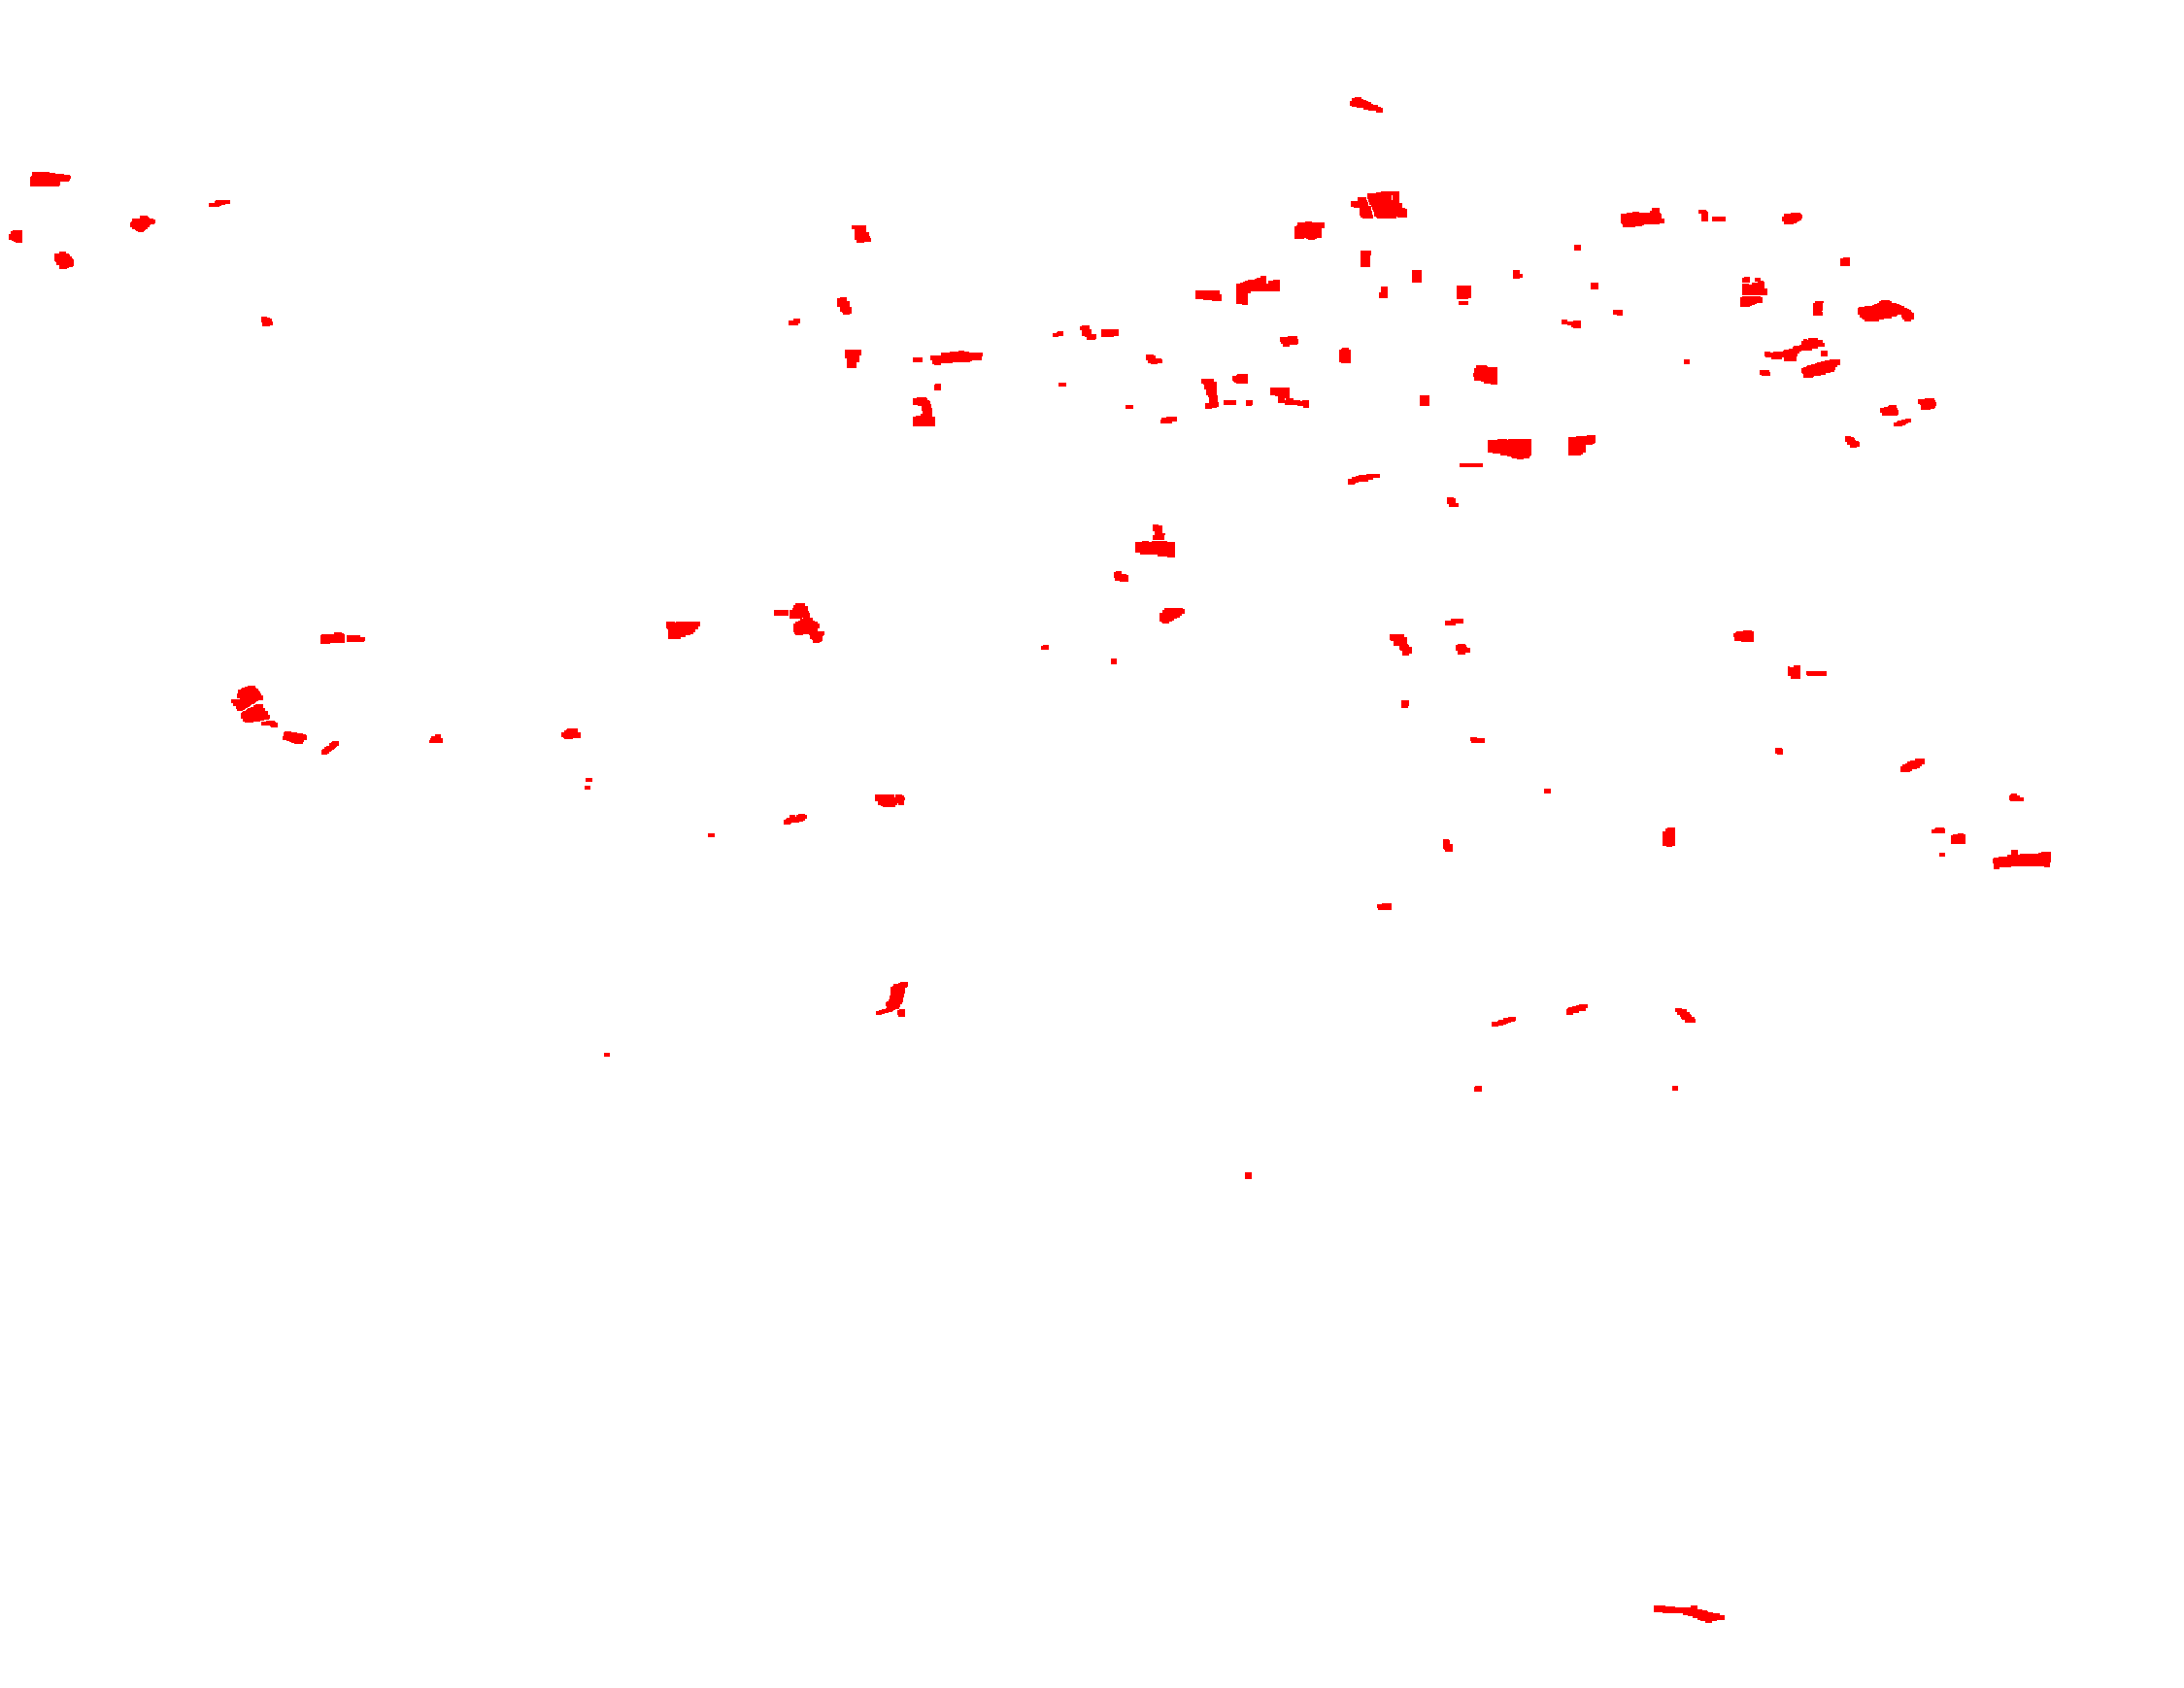

In [44]:
# Reproject the raster
reproject_raster(
    f"{results_dir}/harvested_fields.tif",
    f"{results_dir}/harvested_fields_4326.tif",
    4326,
    method="nearest",
)

# Open the reprojected raster
harvested_4326 = rio.open(f"{results_dir}/harvested_fields_4326.tif")

# Plot on the interactive map
fmap = folium.Map(
    [aoi.iloc[0].geometry.centroid.y, aoi.iloc[0].geometry.centroid.x],
    zoom_start=11,
    tiles="cartodbpositron",
)

folium.raster_layers.ImageOverlay(
    image=harvested_4326.read(1),
    bounds=[
        [harvested_4326.bounds.bottom, harvested_4326.bounds.left],
        [harvested_4326.bounds.top, harvested_4326.bounds.right],
    ],
    colormap=lambda x: (1, 0, 0, x),
).add_to(fmap)

fmap

In [45]:
# Don't forget to close the opened raster
harvested_4326.close()

# Part 2: Sentinel Hub workflow <a id='sh_workflow'></a>

In contrast to the traditional method, only a few steps are required when using the Sentinel Hub API. This is because Sentinel Hub performs the data processing steps such as tiling and mosaicking automatically. So instead of downloading 4 separate scenes like before, we only access the pixels we actually need. The [Sentinel Hub APIs](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub.html) are part of the Copernicus Data Space Ecosystem and can be used to access data in a much more optimised way.

In the following cells we will use [Sentinelhub-py](https://sentinelhub-py.readthedocs.io/en/latest/) to access the API. To do this, you will need a Copernicus Data Space Ecosystem account and will need to set your credentials in `creds.py`.

### 1. Authentication

You can obtain the credentials for the Sentinel Hub services (`client_id` & `client_secret`) in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the user settings, you can create a new OAuth client to generate these credentials. You can find more detailed instructions on the corresponding [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions for configuring your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions, you can create a profile specifically tailored to use the package to access the Copernicus Data Space Ecosystem data collections. This is useful because changes to the Config class in your notebook are usually only temporary. If you save the configuration in your profile, you do not have to generate new credentials or overwrite/change the default profile every time you start or write a new Jupyter notebook.

If you are using the Sentinel Hub Python package for the Copernicus Data Space Ecosystem for the first time, you should create a profile specifically for the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [46]:
# Only run this cell if you have not created a configuration.

# config = SHConfig()
# config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")

Enter your SentinelHub client id ········
Enter your SentinelHub client secret ········


However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `<profile_name>`.

In [47]:
config = SHConfig("cdse")

### 2. Convert AOI to a Sentinel Hub object

In [48]:
full_geometry = Geometry(aoi.to_crs(32630).geometry.values[0], crs=CRS.UTM_30N)

### 3. Write an Evalscript

An [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html) (or "custom script") is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return. It is a required part of any process, batch processing or OGC request.

In the following Evalscript we will perform all the processing steps that we performed in the "traditional" approach.

In [49]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B04", "B08", "B11"],
    output: [{id: "ndvi_t1", bands: 1, sampleType: "FLOAT32"},
             {id: "ndvi_t2", bands: 1, sampleType: "FLOAT32"},
             {id: "bsi_t2", bands: 1, sampleType: "FLOAT32"},
             {id: "harvested", bands: 1, sampleType: "UINT8"}],
    mosaicking: "ORBIT"
  };
}

function preProcessScenes (collections) {
    var allowedDates = ["2023-04-19", "2023-07-08"]; //before and after image dates
    collections.scenes.orbits = collections.scenes.orbits.filter(function (orbit) {
        var orbitDateFrom = orbit.dateFrom.split("T")[0];
        return allowedDates.includes(orbitDateFrom);
    });
    return collections;
}

function evaluatePixel(samples, scenes) {
  // Compute ndvi for all dates
  var ndvi = [];
  for (i=0; i<samples.length; i++){
    ndvi.push((samples[i].B08 - samples[i].B04) / (samples[i].B08 + samples[i].B04));
  }

  // Compute bsi for latest date
  var bsi = ((samples[0].B11 + samples[0].B04) - (samples[0].B08 + samples[0].B02)) / 
    ((samples[0].B11 + samples[0].B04) + (samples[0].B08 + samples[0].B02));

  // Compute harvested map
  var harvested = ((ndvi[1] - ndvi[0] > 0.1 && bsi > 0.1)) ? 1 : 0;

  return {
    "ndvi_t1": [ndvi[1]],
    "ndvi_t2": [ndvi[0]],
    "bsi_t2": [bsi],
    "harvested": [harvested]
  };
}
"""

### 4. Build the request

We build the request according to the [API Reference](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/ApiReference.html), using the `SentinelHubRequest` class. Each Process API request also needs an [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html). An evalscript (or "custom script") is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return. It is a required part of any [process](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process.html), [batch processing](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Batch.html) or [OGC request](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/OGC.html).

The information that we specify in the `SentinelHubRequest` object is:
- an evalscript,
- a list of input data collections with time interval,
- a format of the response,
- a bounding box and its size (size or resolution).
- `mosaickingOrder` (optional): in this example we have used `leastCC` which will return pixels from the least cloudy acquisition in the specified time period.


In [51]:
request = SentinelHubRequest(
    evalscript=evalscript,
    geometry=full_geometry,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2023-04-01", "2023-08-01"),
        )
    ],
    responses=[
        SentinelHubRequest.output_response("ndvi_t1", MimeType.TIFF),
        SentinelHubRequest.output_response("ndvi_t2", MimeType.TIFF),
        SentinelHubRequest.output_response("bsi_t2", MimeType.TIFF),
        SentinelHubRequest.output_response("harvested", MimeType.TIFF),
    ],
    resolution=(10, 10),
    data_folder=results_dir,
    config=config,
)

### 5. Run the request

In [52]:
sh_request = request.get_data(save_data=True)

### 6. Plot the results

In the next cells, we will plot the different products obtained from our Sentinel Hub request.

We will start with the NDVI product for the first date.

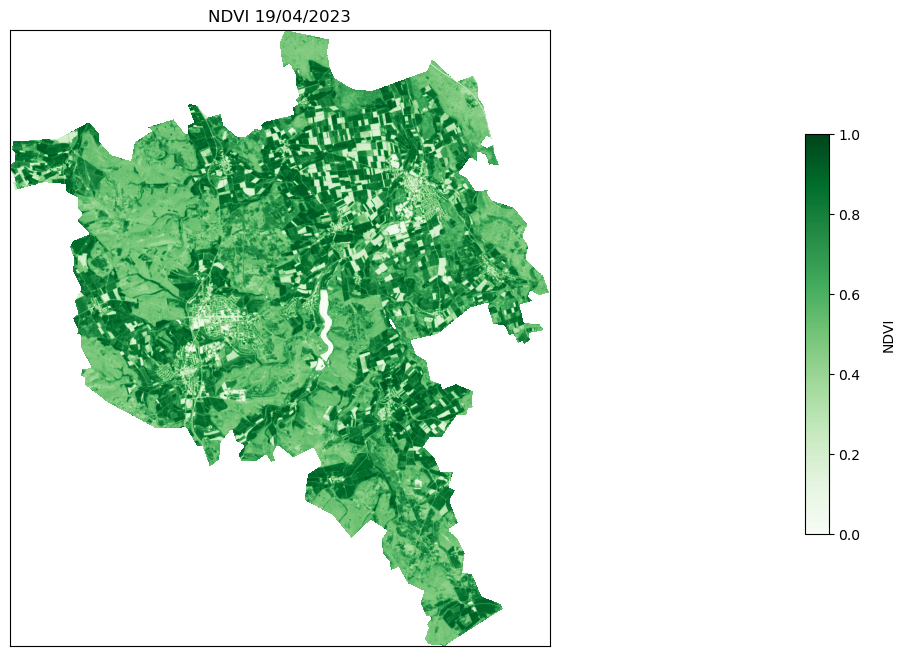

In [53]:
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(sh_request[0]["ndvi_t1.tif"], cmap="Greens", vmin=0, vmax=1)
cax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cax, orientation="vertical")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("NDVI", rotation=90)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("NDVI 19/04/2023")
plt.show()

Next, we will plot the NDVI product for the second date.

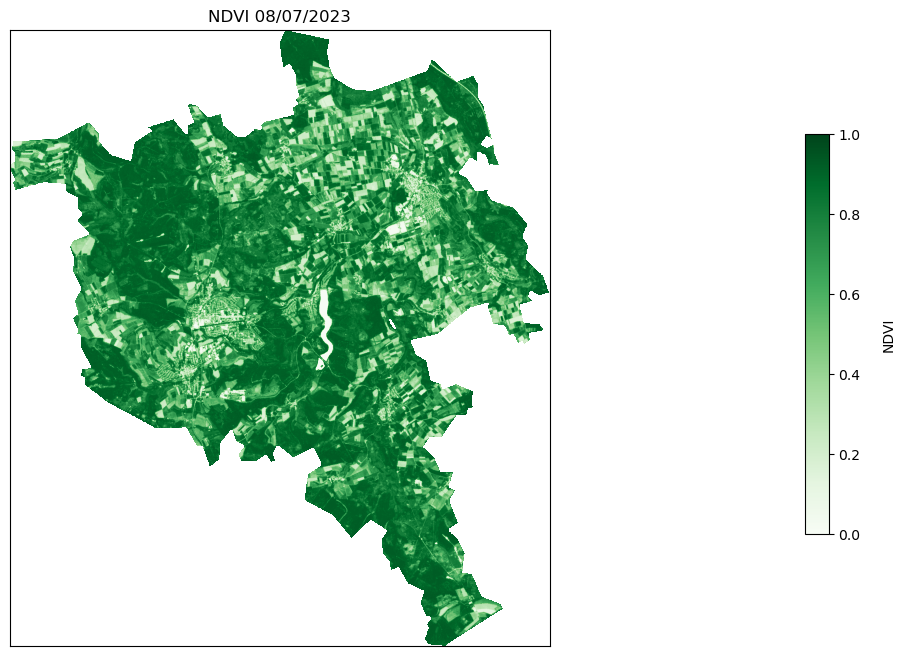

In [54]:
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(sh_request[0]["ndvi_t2.tif"], cmap="Greens", vmin=0, vmax=1)
cax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cax, orientation="vertical")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("NDVI", rotation=90)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("NDVI 08/07/2023")
plt.show()

In the following cell we will plot the BSI for the second date.

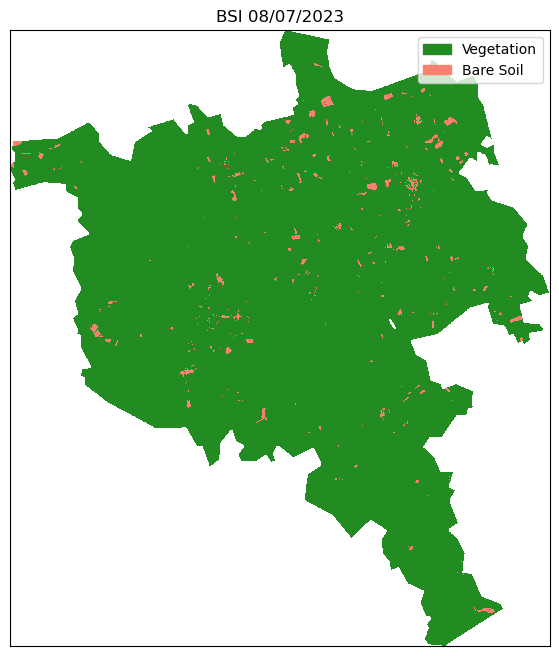

In [55]:
cmap_bsi = colors.ListedColormap(["forestgreen", "salmon"])
bounds_bsi = [-10, 0.15, 10]
norm_bsi = colors.BoundaryNorm(bounds_bsi, cmap_bsi.N)

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(sh_request[0]["bsi_t2.tif"], cmap=cmap_bsi, norm=norm_bsi)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(
    handles=[
        mpatches.Patch(color="forestgreen", label="Vegetation"),
        mpatches.Patch(color="salmon", label="Bare Soil"),
    ]
)
ax.set_title("BSI 08/07/2023")

plt.show()

Next, we plot the "harvested" product.

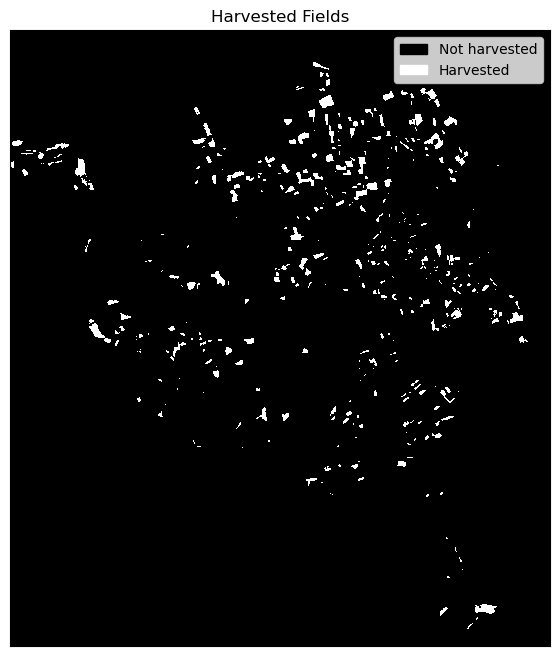

In [56]:
cmap_harvested = colors.ListedColormap(["black", "white"])
bounds_harvested = [0, 0.5, 1]
norm_harvested = colors.BoundaryNorm(bounds_harvested, cmap_harvested.N)

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(sh_request[0]["harvested.tif"], cmap=cmap_harvested, norm=norm_harvested)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(
    handles=[
        mpatches.Patch(color="black", label="Not harvested"),
        mpatches.Patch(color="white", label="Harvested"),
    ]
)
ax.set_title("Harvested Fields")

plt.show()

#### Clean up the harvest map

One of the limitations of Sentinel Hub services is that it fumctions on a per-pixel basis. Therefore to perform a morphological operation on the results we will open the raster and apply the last step on the downloaded file.

The first step consists in decompressing the `tar` file returned by the service.

In [57]:
results_tar = tarfile.open(f"{request.data_folder}/{request.get_filename_list()[0]}")
results_tar.extractall(f"{results_dir}/sh_results")
results_tar.close()

We then open the raster with `rasterio` and clean the data as we did in the "traditional" approach. We save the output, as well as the reprojected version to be able to plot the data interactively.

In [58]:
sh_harvested = rio.open(f"{results_dir}/sh_results/harvested.tif")

# Clean up dataset
sh_harvested_cleaned = morphology.binary_opening(
    sh_harvested.read(1), structure=np.ones((5, 5))
).astype(np.int8)

# Save the output
write_raster(
    f"{results_dir}/sh_results/harvested_fields.tif",
    sh_harvested_cleaned.astype("uint8"),
    sh_harvested.crs,
    sh_harvested.transform,
    0,
)

# Reproject to EPSG 4326
reproject_raster(
    f"{results_dir}/sh_results/harvested_fields.tif",
    f"{results_dir}/sh_results/harvested_fields_4326.tif",
    4326,
    method="nearest",
)

sh_harvested.close()

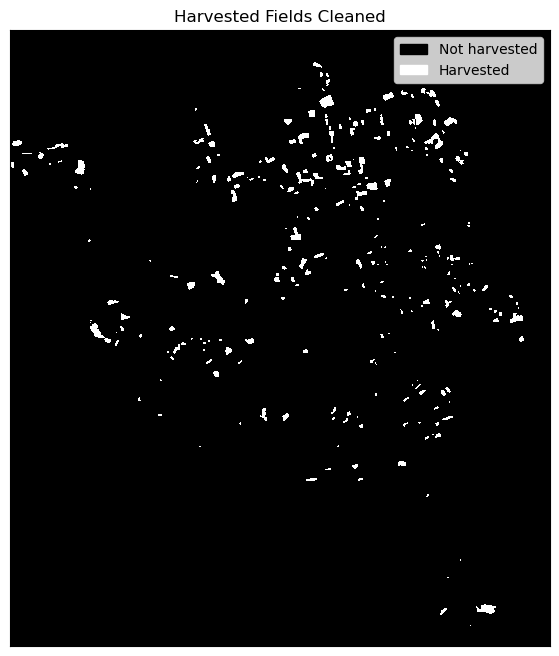

In [59]:
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(sh_harvested_cleaned, cmap=cmap_harvested, norm=norm_harvested)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(
    handles=[
        mpatches.Patch(color="black", label="Not harvested"),
        mpatches.Patch(color="white", label="Harvested"),
    ]
)
ax.set_title("Harvested Fields Cleaned")

plt.show()

We now plot the data on an interactive map.


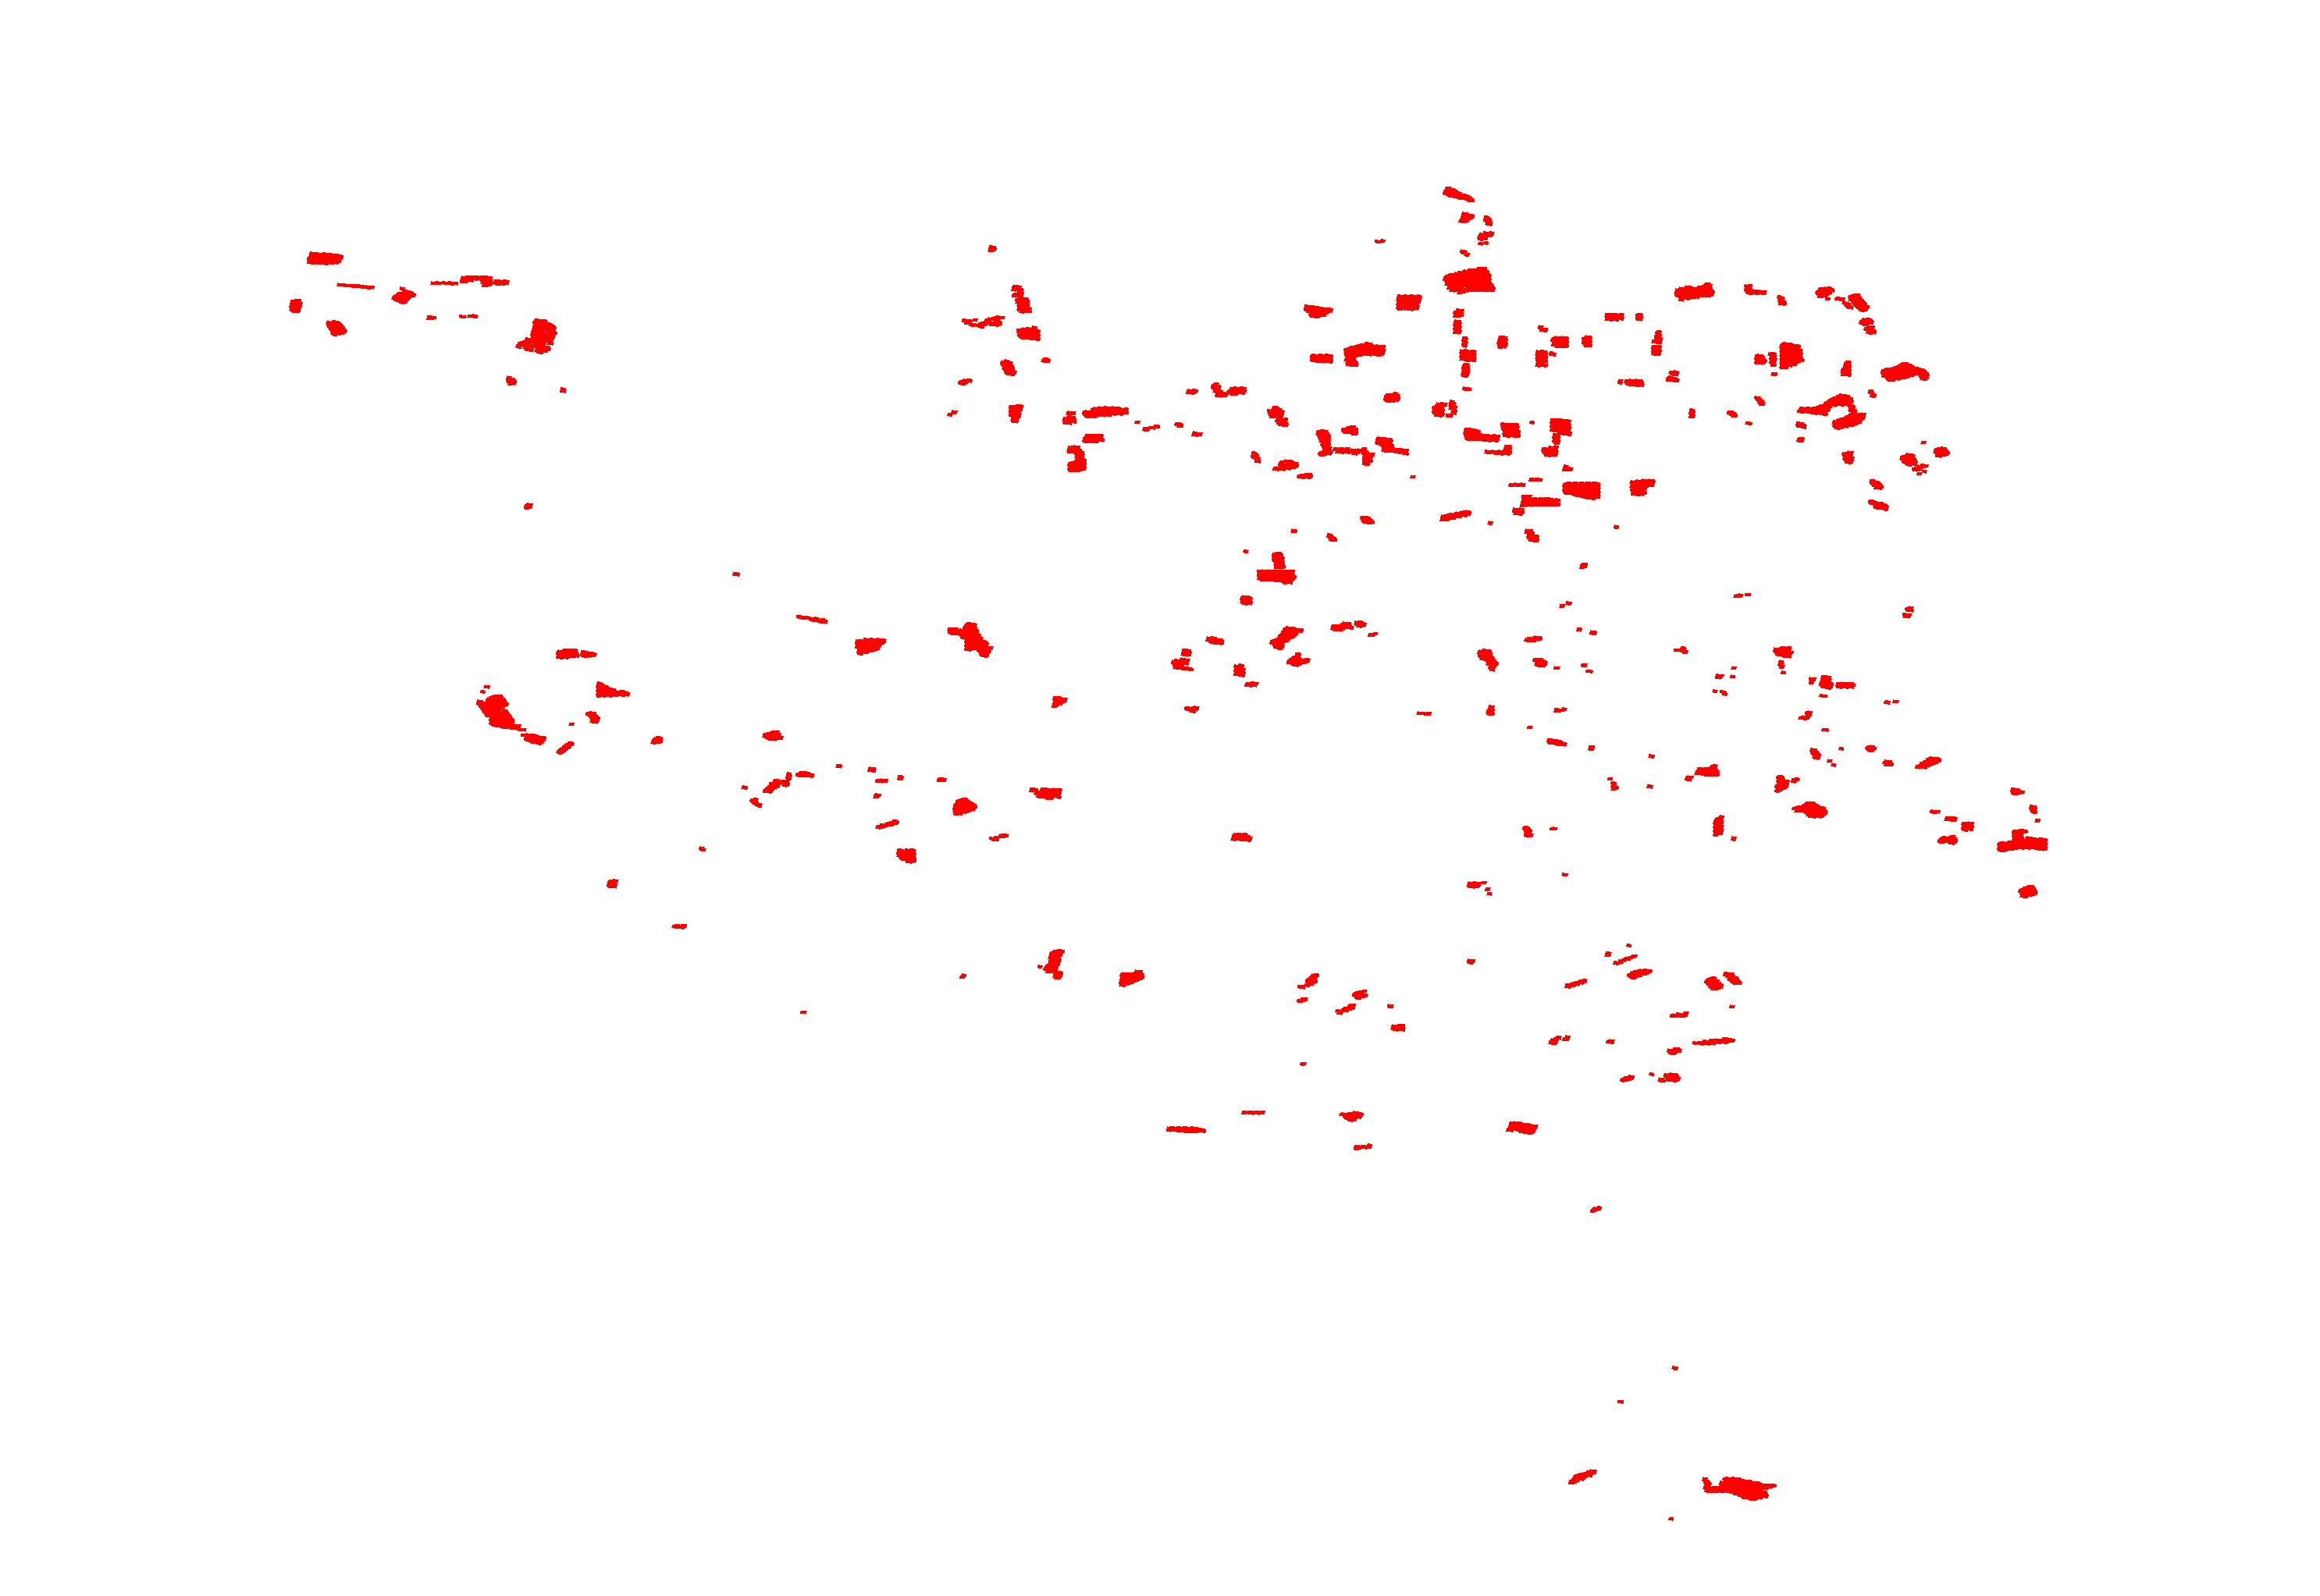

In [60]:
# Open reprojected raster
sh_harvested_4326 = rio.open(f"{results_dir}/sh_results/harvested_fields_4326.tif")

# Create map
fmap = folium.Map(
    [aoi.iloc[0].geometry.centroid.y, aoi.iloc[0].geometry.centroid.x],
    zoom_start=12,
    tiles="cartodbpositron",
)

folium.raster_layers.ImageOverlay(
    image=sh_harvested_4326.read(1),
    bounds=[
        [sh_harvested_4326.bounds.bottom, sh_harvested_4326.bounds.left],
        [sh_harvested_4326.bounds.top, sh_harvested_4326.bounds.right],
    ],
    colormap=lambda x: (1, 0, 0, x),
).add_to(fmap)

fmap

In [61]:
# Close dataset
sh_harvested_4326.close()